# This work employs deep convolution neural network model to distinguish between fresh and rotten products in three popular fruits, apple, orange and banana. An accuracy of 99% was reached with both VGG16 and ResNet101 models

In [1]:
# Importing necessary modules
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import random
import os

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from PIL import Image 


from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

from sklearn.metrics import confusion_matrix,classification_report

In [2]:
# Image processing libraries
!pip install imutils
import cv2
import os
from imutils import paths

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25861 sha256=6e712a6d00db783789657bdeec93bdd1b52ddb9efcebd774b4da843d353ce44e
  Stored in directory: /root/.cache/pip/wheels/35/e4/69/cb99d996d14a2971b79b990d68b05a17d58ce530ff96090dfc
Successfully built imutils


In [14]:
#Fetching the fresh train and validation data.
import os
FRESH_PATH = "/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset"
FRESH_TRAIN_PATH = os.path.sep.join([FRESH_PATH, "train"])
FRESH_TEST_PATH = os.path.sep.join([FRESH_PATH, "test"])

# Get total number of images per class
freshTotalTrain = len(list(paths.list_images(FRESH_TRAIN_PATH)))
freshTotalTest = len(list(paths.list_images(FRESH_TEST_PATH)))

In [ ]:
#Creating the CLAHE Function
clahe = cv2.createCLAHE(clipLimit=10,tileGridSize=(8,8))

def apply_clahe(img):
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img[:,:,0] = clahe.apply(img[:,:,0])
    img = cv2.cvtColor(img, cv2.COLOR_Lab2RGB)
    return img

## Apply CLAHE to all images and save to the destination directory

In [ ]:
# Define the source directory containing the images
source_dir = "/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset"

# Define the destination directory to save the processed images
destination_dir = "/kaggle/working/fruits-fresh-and-rotten-for-classification/clahe-dataset"

for subdir, dirs, files in os.walk(source_dir):
    for file in files:
        # Get the full file path
        file_path = os.path.join(subdir, file)
        
        # Load the image using OpenCV
        image = cv2.imread(file_path)
        
        # Apply the custom function to process the image
        processed_image = apply_clahe(image)
        
        # Get the relative path of the image with respect to the source directory
        relative_path = os.path.relpath(file_path, source_dir)
        
        # Construct the destination path to save the processed image
        destination_path = os.path.join(destination_dir, relative_path)
        
        # Create the destination directory if it does not exist
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        
        # Save the processed image to the destination directory
        cv2.imwrite(destination_path, processed_image)

In [3]:
#Fetch CLAHE-converted images
import os
BASE_PATH = "/kaggle/working/fruits-fresh-and-rotten-for-classification/clahe-dataset"
TRAIN_PATH = os.path.sep.join([BASE_PATH, "train"])
TEST_PATH = os.path.sep.join([BASE_PATH, "test"])

# Get total number of images per class
totalTrain = len(list(paths.list_images(TRAIN_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))

## Show comparison between fresh and CLAHE-applied images

In [15]:
img1  = Image.open(TRAIN_PATH+"/freshapples/Screen Shot 2018-06-08 at 4.59.49 PM.png")
img2 = np.array(Image.open(TRAIN_PATH+"/rottenapples/Screen Shot 2018-06-07 at 2.15.50 PM.png"))
fresh_img1  = Image.open(FRESH_TRAIN_PATH+"/freshapples/Screen Shot 2018-06-08 at 4.59.49 PM.png")
fresh_img2 = np.array(Image.open(FRESH_TRAIN_PATH+"/rottenapples/Screen Shot 2018-06-07 at 2.15.50 PM.png"))

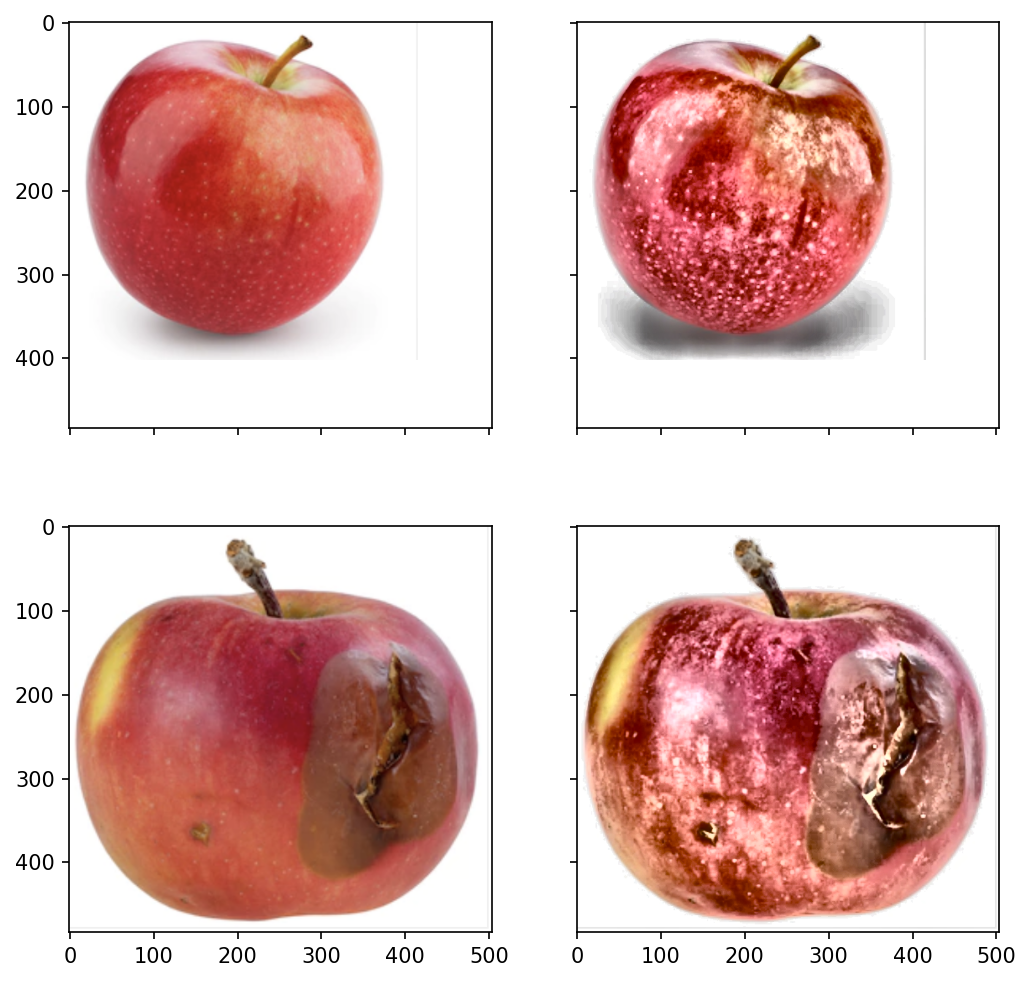

In [16]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (8, 8), dpi = 150, num = 1)
ax1.imshow(fresh_img1)
ax2.imshow(img1)
ax3.imshow(fresh_img2)
ax4.imshow(img2)

In [ ]:
import shutil
shutil.make_archive('clahe-dataset', 'zip', destination_dir)

In [4]:
# Getting labels of training data
labels = os.listdir(TRAIN_PATH)
print("Classes names:")
print(".............")
labels

Classes names:
.............


['rottenbanana',
 'freshoranges',
 'freshapples',
 'rottenoranges',
 'freshbanana',
 'rottenapples']

In [5]:
# Initialize the training data for augmentation 
trainAug= ImageDataGenerator(
    validation_split = 0.2,
	rescale=1./255,
	rotation_range=25,
	zoom_range=0.2,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.2,
	horizontal_flip=True,
	fill_mode="nearest")

testAug= ImageDataGenerator(rescale=1. / 255)

In [6]:
# initialize the training generator
train_generator = trainAug.flow_from_directory(
	TRAIN_PATH,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=32,
    subset = "training")

val_generator = trainAug.flow_from_directory(
	TRAIN_PATH,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=32,
    subset = "validation")


# initialize the validation generator
test_generator = testAug.flow_from_directory(
	TEST_PATH,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False)

Found 8723 images belonging to 6 classes.
Found 2178 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


## Creating the utility model evaluation function

In [7]:
import seaborn as sns
from matplotlib import pyplot

def data_viz(model, history):
  pyplot.style.use("ggplot")
  # sns.set()
  fig = pyplot.figure(0, (12, 4))

  ax = pyplot.subplot(1, 2, 1)
  pyplot.plot(np.arange(0, len(history.epoch)), history.history["accuracy"], label="train_accuracy")
  pyplot.plot(np.arange(0, len(history.epoch)), history.history["val_accuracy"], label="val_accuracy")
  pyplot.title(""+ model + " Training and Validation Accuracy")
  pyplot.xlabel("Epoch #")
  pyplot.ylabel("Accuracy")
  pyplot.legend(loc="lower right")
  pyplot.title('Accuracy')
  pyplot.tight_layout()

  ax = pyplot.subplot(1, 2, 2)
  pyplot.plot(np.arange(0, len(history.epoch)), history.history["loss"], label="train_loss")
  pyplot.plot(np.arange(0, len(history.epoch)), history.history["val_loss"], label="val_loss")
  pyplot.title(""+ model + " Training and Validation Loss")
  pyplot.xlabel("Epoch #")
  pyplot.ylabel("Loss")
  pyplot.legend(loc="upper right")
  pyplot.tight_layout()

  pyplot.show()

# Using VGG 16

In [20]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [21]:
input_shape = (224, 224, 3)
n_classes=6
conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [22]:
# Freeze base model
conv_base.trainable = False

In [25]:
from keras.models import Model
from keras.layers import *

# Create inputs with correct shape
inputs = Input(shape=(224, 224, 3))

x = conv_base(inputs, training=False)

# Add pooling layer or flatten layer
x = Flatten()(x)

# Add a hidden layer
x = Dense(256, activation='relu')(x)

# Add a dropout layer
x = Dropout(.5)(x)

# Add final dense layer
outputs = Dense(6, activation = 'softmax')(x)

# Combine inputs and outputs to create model
vgg_model_clahe = Model(inputs, outputs)
vgg_model_clahe.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 21,139,014
Trainable params: 6,424,326
Non-tr

In [27]:
vgg_model_clahe.compile(loss='categorical_crossentropy',
              metrics=["accuracy"],
             optimizer = 'nadam')
checkpoint_filepath = 'vgg16_model_best_weights.h5'
# Model weights are saved at the end of every epoch, if it's the best seen so far.
vgg_checkpoint_clahe = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)

vgg_history_clahe = vgg_model_clahe.fit(train_generator,validation_data=val_generator,
                              steps_per_epoch=train_generator.samples/train_generator.batch_size,
                              epochs=16,
                              validation_steps=val_generator.samples/val_generator.batch_size, callbacks=[vgg_checkpoint_clahe]
)

Epoch 1/16
273/272 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.7728
Epoch 1: val_accuracy improved from -inf to 0.93985, saving model to vgg16_model_best_weights.h5
272/272 [==============================] - 175s 607ms/step - loss: 0.6603 - accuracy: 0.7728 - val_loss: 0.1822 - val_accuracy: 0.9399
Epoch 2/16
273/272 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.8691
Epoch 2: val_accuracy improved from 0.93985 to 0.94858, saving model to vgg16_model_best_weights.h5
272/272 [==============================] - 162s 594ms/step - loss: 0.3613 - accuracy: 0.8691 - val_loss: 0.1512 - val_accuracy: 0.9486
Epoch 3/16
273/272 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.8841
Epoch 3: val_accuracy improved from 0.94858 to 0.96189, saving model to vgg16_model_best_weights.h5
272/272 [==============================] - 160s 588ms/step - loss: 0.3158 - accuracy: 0.8841 - val_loss: 0.1125 - val_accuracy: 0.9619
Epoch 4/16

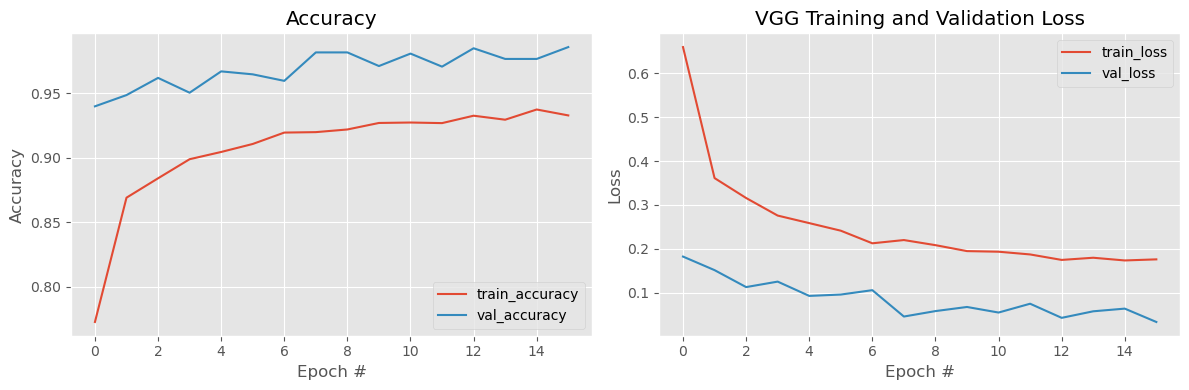

84/84 [==============================] - 15s 180ms/step - loss: 0.0306 - accuracy: 0.9893


In [34]:
data_viz("VGG", vgg_history_clahe)
vgg_loss, vgg_accuracy = vgg_model_clahe.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size)

In [37]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = vgg_model_clahe.predict(test_generator, steps=test_generator.samples/test_generator.batch_size)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')
target_names = ['Rotten oranges','Fresh Banana', 'fresh Oranges', 'Rotten Apples', 'Fresh Apples', 'Rotten Banana']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

84/84 [==============================] - 14s 165ms/step
Confusion Matrix
[[386   0   1   8   0   0]
 [  0 380   0   0   1   0]
 [  2   1 380   3   0   2]
 [  1   0   0 599   0   1]
 [  0   3   0   0 527   0]
 [  0   0   3   3   0 397]]
Classification Report
                precision    recall  f1-score   support

Rotten oranges       0.99      0.98      0.98       395
  Fresh Banana       0.99      1.00      0.99       381
 fresh Oranges       0.99      0.98      0.98       388
 Rotten Apples       0.98      1.00      0.99       601
  Fresh Apples       1.00      0.99      1.00       530
 Rotten Banana       0.99      0.99      0.99       403

      accuracy                           0.99      2698
     macro avg       0.99      0.99      0.99      2698
  weighted avg       0.99      0.99      0.99      2698



In [38]:
vgg_model_clahe.save('/kaggle/working/'+checkpoint_filepath)

# Using ResNet-50

In [44]:
from tensorflow.keras.applications import ResNet101V2

In [46]:
input_shape = (224, 224, 3)
n_classes=6
resnet_base = ResNet101V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

171317808/171317808 [==============================] - 1s 0us/step


In [47]:
# Freeze base model
resnet_base.trainable = False

In [48]:
from keras.models import Model
from keras.layers import *

# Create inputs with correct shape
inputs = Input(shape=(224, 224, 3))

x = resnet_base(inputs, training=False)

# Add pooling layer or flatten layer
x = Flatten()(x)

# Add a hidden layer
x = Dense(256, activation='relu')(x)

# Add a dropout layer
x = Dropout(.5)(x)

# Add final dense layer
outputs = Dense(6, activation = 'softmax')(x)

# Combine inputs and outputs to create model
resnet_model = Model(inputs, outputs)
resnet_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 68,318,470
Trainable params: 25,691,910
Non-t

Epoch 1/16
273/272 [==============================] - ETA: 0s - loss: 1.2012 - accuracy: 0.8346
Epoch 1: val_accuracy improved from -inf to 0.94812, saving model to resnet_model_best_weights.h5
272/272 [==============================] - 180s 635ms/step - loss: 1.2012 - accuracy: 0.8346 - val_loss: 0.2129 - val_accuracy: 0.9481
Epoch 2/16
273/272 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.8770
Epoch 2: val_accuracy improved from 0.94812 to 0.97107, saving model to resnet_model_best_weights.h5
272/272 [==============================] - 166s 608ms/step - loss: 0.4387 - accuracy: 0.8770 - val_loss: 0.1021 - val_accuracy: 0.9711
Epoch 3/16
273/272 [==============================] - ETA: 0s - loss: 0.3167 - accuracy: 0.9115
Epoch 3: val_accuracy improved from 0.97107 to 0.98026, saving model to resnet_model_best_weights.h5
272/272 [==============================] - 166s 607ms/step - loss: 0.3167 - accuracy: 0.9115 - val_loss: 0.0622 - val_accuracy: 0.9803
Epoch 4

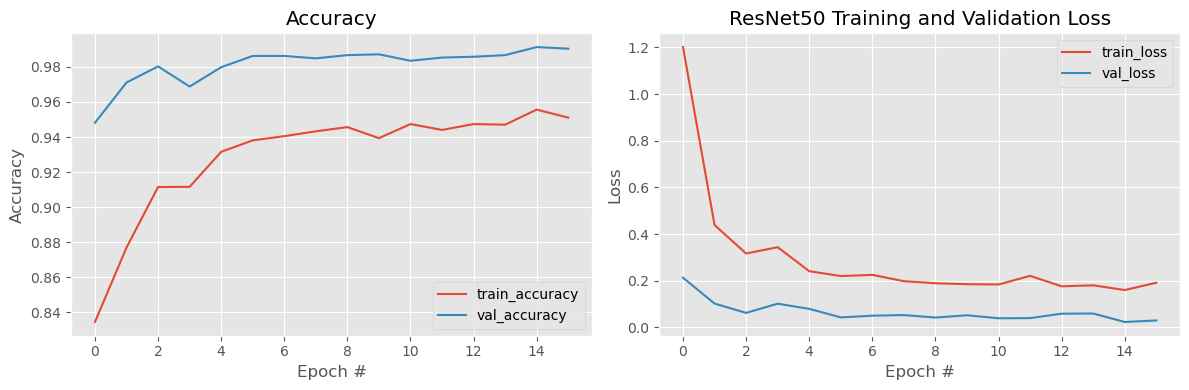

84/84 [==============================] - 18s 213ms/step - loss: 0.0314 - accuracy: 0.9904


In [49]:
resnet_model.compile(loss='categorical_crossentropy',
              metrics=["accuracy"],
             optimizer = 'nadam')
resnet_checkpoint_filepath = 'resnet_model_best_weights.h5'
# Model weights are saved at the end of every epoch, if it's the best seen so far.
resnet_checkpoint = ModelCheckpoint(filepath=resnet_checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)

resnet_history = resnet_model.fit(train_generator,validation_data=val_generator,
                              steps_per_epoch=train_generator.samples/train_generator.batch_size,
                              epochs=16,
                              validation_steps=val_generator.samples/val_generator.batch_size, callbacks=[resnet_checkpoint]
)

data_viz("ResNet50", resnet_history)
resnet_loss, resnet_accuracy = resnet_model.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size)
resnet_model.save('/kaggle/working/'+resnet_checkpoint_filepath)

In [50]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = resnet_model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')
target_names = ['Rotten oranges','Fresh Banana', 'fresh Oranges', 'Rotten Apples', 'Fresh Apples', 'Rotten Banana']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

84/84 [==============================] - 16s 174ms/step
Confusion Matrix
[[389   0   0   6   0   0]
 [  0 381   0   0   0   0]
 [  5   0 379   1   0   3]
 [  6   0   0 595   0   0]
 [  0   2   0   0 528   0]
 [  0   0   0   3   0 400]]
Classification Report
                precision    recall  f1-score   support

Rotten oranges       0.97      0.98      0.98       395
  Fresh Banana       0.99      1.00      1.00       381
 fresh Oranges       1.00      0.98      0.99       388
 Rotten Apples       0.98      0.99      0.99       601
  Fresh Apples       1.00      1.00      1.00       530
 Rotten Banana       0.99      0.99      0.99       403

      accuracy                           0.99      2698
     macro avg       0.99      0.99      0.99      2698
  weighted avg       0.99      0.99      0.99      2698



In [8]:
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Model

input = Input(shape=(224,224,3)) 

x  = Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(input)
x  = MaxPooling2D((2, 2))(x)

x  = Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(x)
x  = Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(x)
x  = MaxPooling2D((2, 2))(x)

x  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(x)
x  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(x)
x  = MaxPooling2D((2, 2))(x)

x  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)

x  = MaxPooling2D((2, 2))(x)


# Add pooling layer or flatten layer
x = Flatten()(x)

# Add a hidden layer
x = Dense(256, activation='relu')(x)

# Add a dropout layer
x = Dropout(.5)(x)

# Add final dense layer
outputs = Dense(6, activation = 'softmax')(x)

# Combine inputs and outputs to create model
cnn_model = Model(input, outputs)
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                         

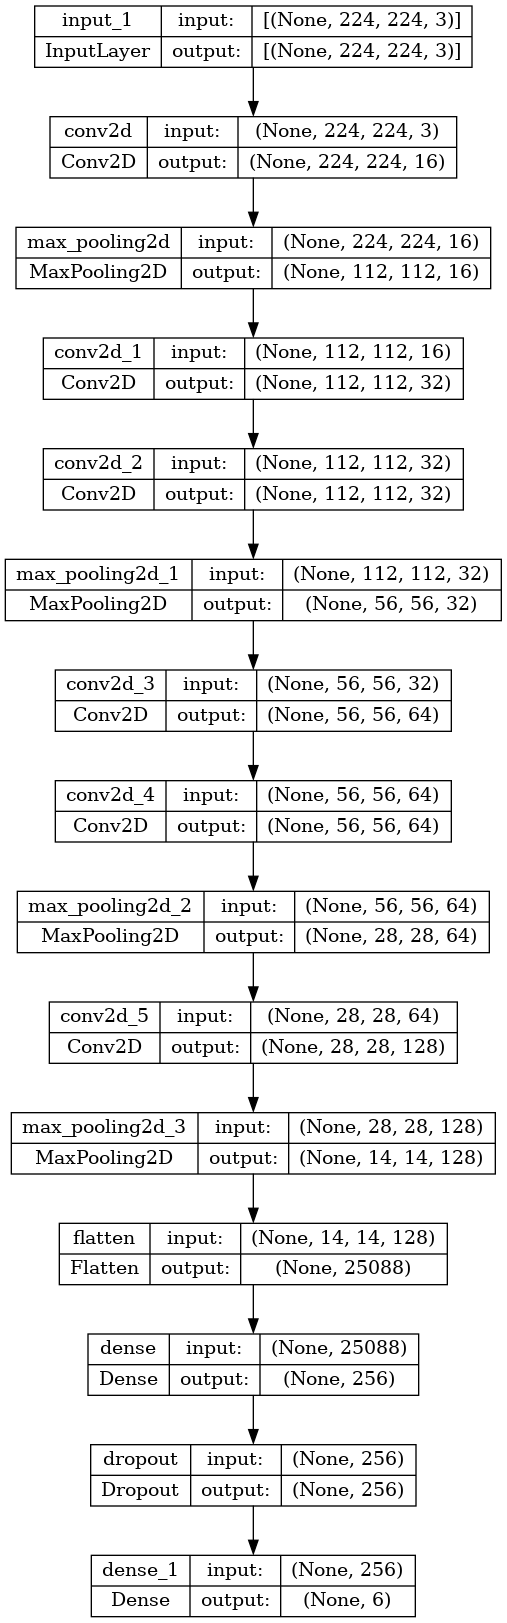

In [40]:
from tensorflow.keras.utils import plot_model
dot_img_file = '/tmp/model_1.png'
plot_model(cnn_model, to_file=dot_img_file, show_shapes=True)

Epoch 1/16
273/272 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9557
Epoch 1: val_accuracy improved from -inf to 0.97842, saving model to cnn_model_best_weights.h5
272/272 [==============================] - 158s 562ms/step - loss: 0.1254 - accuracy: 0.9557 - val_loss: 0.0629 - val_accuracy: 0.9784
Epoch 2/16
273/272 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.9577
Epoch 2: val_accuracy did not improve from 0.97842
272/272 [==============================] - 153s 561ms/step - loss: 0.1203 - accuracy: 0.9577 - val_loss: 0.0503 - val_accuracy: 0.9784
Epoch 3/16
273/272 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9633
Epoch 3: val_accuracy did not improve from 0.97842
272/272 [==============================] - 153s 563ms/step - loss: 0.1159 - accuracy: 0.9633 - val_loss: 0.0660 - val_accuracy: 0.9734
Epoch 4/16
273/272 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9649
Epoch 4: val_a

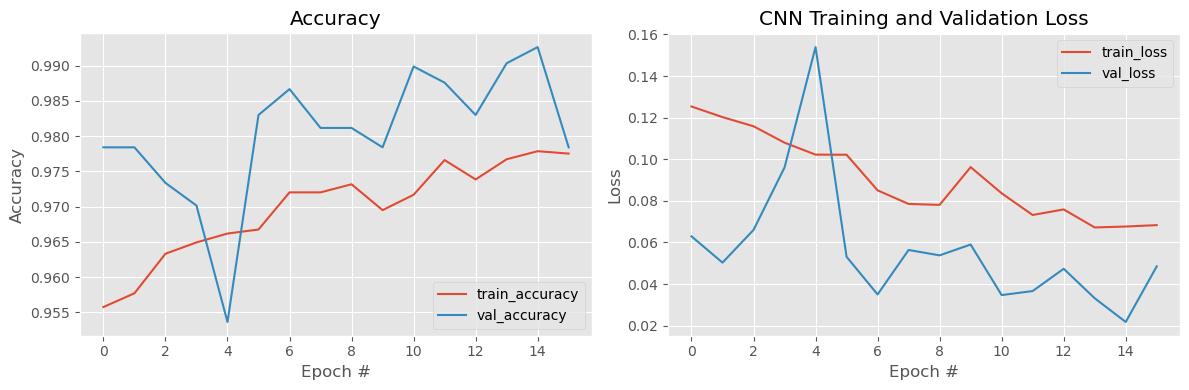

84/84 [==============================] - 13s 154ms/step - loss: 0.0484 - accuracy: 0.9800


In [29]:
cnn_model.compile(loss='categorical_crossentropy',
              metrics=["accuracy"],
             optimizer = 'nadam')
cnn_checkpoint_filepath = 'cnn_model_best_weights.h5'
# Model weights are saved at the end of every epoch, if it's the best seen so far.
cnn_checkpoint = ModelCheckpoint(filepath=cnn_checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)

cnn_history = cnn_model.fit(train_generator,validation_data=val_generator,
                              steps_per_epoch=train_generator.samples/train_generator.batch_size,
                              epochs=16,
                              validation_steps=val_generator.samples/val_generator.batch_size, callbacks=[cnn_checkpoint]
)

data_viz("CNN", cnn_history)
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size)
cnn_model.save('/kaggle/working/'+cnn_checkpoint_filepath)

In [30]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = cnn_model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')
target_names = ['Rotten oranges','Fresh Banana', 'fresh Oranges', 'Rotten Apples', 'Fresh Apples', 'Rotten Banana']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

84/84 [==============================] - 14s 159ms/step
Confusion Matrix
[[385   0   1   9   0   0]
 [  0 381   0   0   0   0]
 [  0   0 377   0   0  11]
 [  1   0   1 573   1  25]
 [  0   0   0   0 530   0]
 [  0   0   2   2   1 398]]
Classification Report
                precision    recall  f1-score   support

Rotten oranges       1.00      0.97      0.99       395
  Fresh Banana       1.00      1.00      1.00       381
 fresh Oranges       0.99      0.97      0.98       388
 Rotten Apples       0.98      0.95      0.97       601
  Fresh Apples       1.00      1.00      1.00       530
 Rotten Banana       0.92      0.99      0.95       403

      accuracy                           0.98      2698
     macro avg       0.98      0.98      0.98      2698
  weighted avg       0.98      0.98      0.98      2698



## Performance Comparison

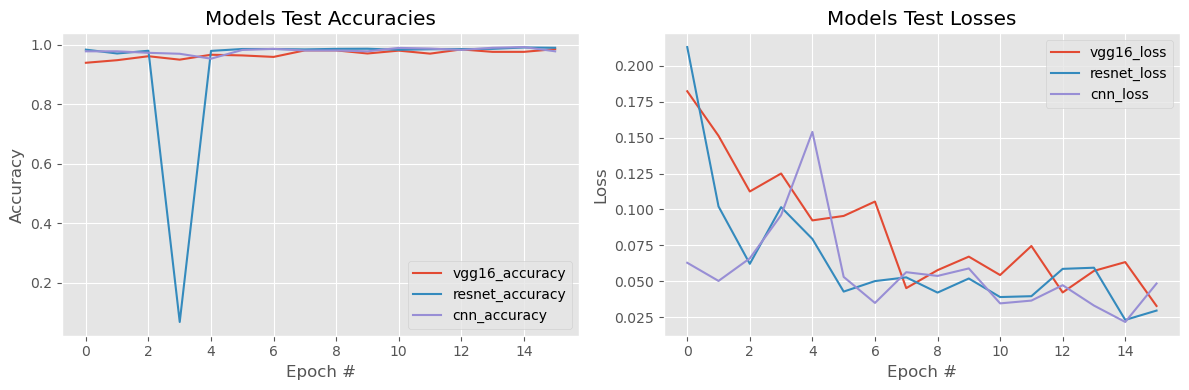

In [36]:
# Graph showing accuracies and losses of the three models
pyplot.style.use("ggplot")
# sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
pyplot.plot(np.arange(0, len(vgg_history.epoch)), vgg_history.history["val_accuracy"], label="vgg16_accuracy")
pyplot.plot(np.arange(0, len(resnet_history.epoch)), resnet_history.history["val_accuracy"], label="resnet_accuracy")
pyplot.plot(np.arange(0, len(cnn_history.epoch)), cnn_history.history["val_accuracy"], label="cnn_accuracy")
pyplot.title("Models Test Accuracies")
pyplot.xlabel("Epoch #")
pyplot.ylabel("Accuracy")
pyplot.legend(loc="lower right")
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
pyplot.plot(np.arange(0, len(vgg_history.epoch)), vgg_history.history["val_loss"], label="vgg16_loss")
pyplot.plot(np.arange(0, len(resnet_history.epoch)), resnet_history.history["val_loss"], label="resnet_loss")
pyplot.plot(np.arange(0, len(cnn_history.epoch)), cnn_history.history["val_loss"], label="cnn_loss")
pyplot.title("Models Test Losses")
pyplot.xlabel("Epoch #")
pyplot.ylabel("Loss")
pyplot.legend(loc="upper right")
pyplot.tight_layout()

pyplot.show()